In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import lightgbm

import optuna.integration as opt
import optuna.integration.lightgbm as lgb_tuner
import optuna

import datetime as dt
import shap

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state, test_size
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *
from src.models import ExpandingPredictionLGB

In [4]:
shap.initjs()

In [5]:
# Load data
model_type = "lgb"
tinterval = 'daily'

year_start = 2012
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

variables = 'FF_TS_VX' # 'FF_TS_VX', 'FF'

name = f'{tinterval}_{variables}_{year_spread}'

df_w = load_data(file_name=f"df_{name}.csv", file_path=OUT_DATA_DIR)
data_dict = load_data(file_name=f"dict_{name}.pkl", file_path=OUT_DATA_DIR)

In [6]:
# update dict with model specific information
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(variables=variables)
data_dict["model_metrics"].update(tinterval=tinterval)
data_dict["model_metrics"].update(model_name=f"{model_type}_{name}_{data_dict['model_features']['predicted']}")

# data selection

In [7]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
     'vixo',
     # 'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     'macd',
     'williamsr',
     'sp_close',
     'sp_close_lag1',
     # 'sp_close_lag2',
     'sp_close_lag3',
     # 'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     # 'sp_close_lag8',
     # 'sp_close_lag9',
     # 'sp_close_lag10',
     # 'sp_close_lag11',
     'sp_close_lag12',
     # 'sp_close_lag13',
     # 'sp_close_lag14',
     # 'sp_close_lag15'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [8]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

# TTS

In [9]:
df_train = df_ws.copy()

In [10]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=test_size,
                                            add_const=False)

# Corr

In [11]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Corr matrix

,VIF,corr_sp_close_lead1
sp_close,1.724737,-0.182489
sp_close_lag7,1.174054,-0.147732
sp_close_lag5,1.157785,-0.132706
sp_close_lag12,1.121160,-0.111969
sp_close_lag3,1.158471,-0.071968
ff_HML,1.596384,-0.031879
williamsr,4.772228,-0.030617
macd,1.383324,-0.026917
ff_RMW,1.095461,0.004679
ff_CMA,1.485115,0.013257


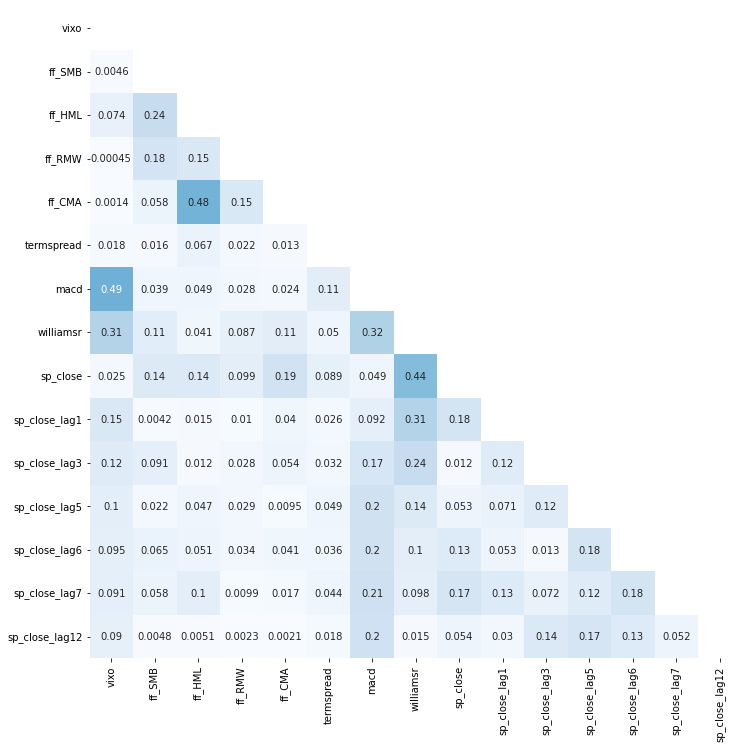

In [12]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             # size_factor=1,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

In [13]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

# Tuner

In [28]:
tuner_params = {
    'objective': 'regression',
    'metric': ['neg_mean_squared_error', 'l2'],
    'random_state': random_state,
    # 'categorical_feature': [X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]]
}

tuner_train = lightgbm.Dataset(X_train, 
                               y_train,
                               # categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]]
                              )
tuner_eval = lightgbm.Dataset(X_test,
                              y_test,
                              # categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]], 
                              reference=tuner_train)
tuner_eval_results = {}
training_time = 60 * 10

In [29]:
%%capture
my_study = optuna.study.create_study()

t_start = dt.datetime.now()
tuner = lgb_tuner.LightGBMTuner(tuner_params,
                                tuner_train,
                                valid_sets=tuner_eval,
                                study=my_study,
                                num_boost_round=1000,
                                time_budget=training_time,
                                callbacks=[lightgbm.early_stopping(10000), lightgbm.record_evaluation(tuner_eval_results)])
tuner.run()
t_end = dt.datetime.now()

[I 2022-05-02 20:40:09,202] A new study created in memory with name: no-name-a4b06656-b55c-438c-908e-9ffa77456296
[I 2022-05-02 20:40:11,481] Trial 0 finished with value: 7.343714240558133e-05 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 7.343714240558133e-05.
[I 2022-05-02 20:40:13,933] Trial 1 finished with value: 7.111885623331635e-05 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 7.111885623331635e-05.
[I 2022-05-02 20:40:16,263] Trial 2 finished with value: 7.111885623331635e-05 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 7.111885623331635e-05.
[I 2022-05-02 20:40:18,385] Trial 3 finished with value: 7.111885623331635e-05 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 7.111885623331635e-05.
[I 2022-05-02 20:40:20,580] Trial 4 finished with value: 7.111885623331635e-05 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 7.111885623331635e-05.
[I 202

In [30]:
print(f'Parameters where tuned for {t_end - t_start}')
print(f'Max training time was {training_time}')

Parameters where tuned for 0:03:09.101296
Max training time was 600


In [31]:
params = tuner.best_params
params = {item: params[item] for item in params.keys() if item != "categorical_feature"}

In [32]:
params

{'objective': 'regression',
 'metric': ['neg_mean_squared_error', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 24,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [33]:
# params = {'objective': 'regression',
#           'metric': ['neg_mean_squared_error', 'l2'],
#           'random_state': random_state
#          }

# Model

In [34]:
lgb_wrapper = ExpandingPredictionLGB(model_in=lightgbm,
                                     X_train=X_train, 
                                     y_train=y_train,
                                     X_test=X_test,
                                     y_test=y_test,
                                     params=params,
                                     # categorical_features=data_dict['model_features']['categorical'], 
                                     debug_single_pred=False)

In [35]:
data_dict['model_features'].update(params=lgb_wrapper.params)

# Model eval

In [36]:
%%capture
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=lgb_wrapper,
                          print_results=True)

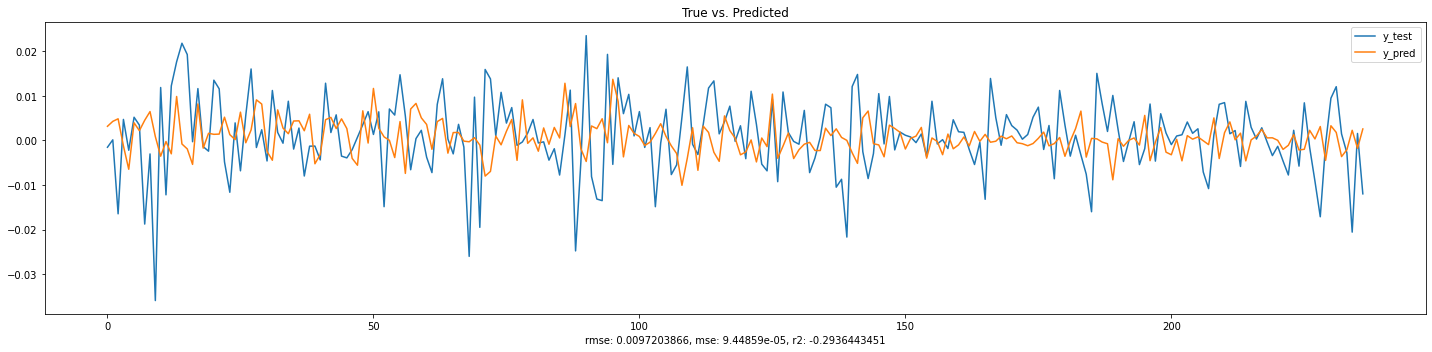

Validation Scores
root mean squared error: 0.0097203866
mean squared error: 9.44859e-05
mean absolute error: 0.0073236654
R2: -0.2936443451


In [37]:
fig_truefit = lgb_eval.get_model_performance()

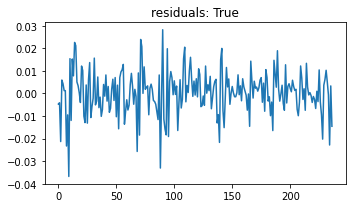

Stationarity Test Results
P-Values: 3.8398278980003594e-28
Test-stats: -15.340246187062368
Time series is stationary: True
Number of lags used: 0




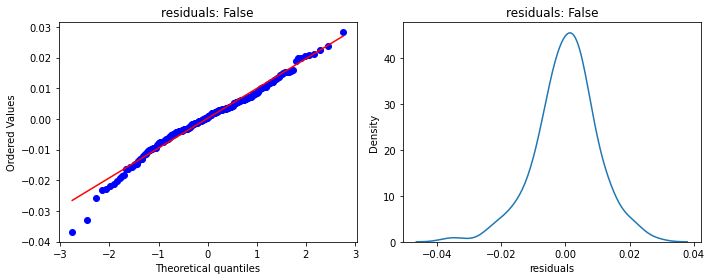

Normality Test Results
P-Values: 0.0010212056591707983
Test-stats: 13.773542661850534
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


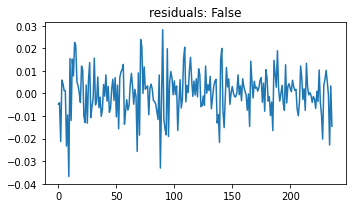

Test for Heteroskedasticity
Test p-value: 0.05511705327289641
Heteroskedasticity is present: False


Ttest_1sampResult(statistic=0.3702778785686874, pvalue=0.7115075528490682)
TTest one sample for mean: 0
Test statistics: 0.3702778785686874
Test pvalue: 0.7115075528490682
Population mean is equal to 0: True


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 2.002 < 2.5
First order autocorrlation is not present: : True



Ljung Box test
Pvalue: 0.4420435830184468
H0 the residuals are idd can be rejected: False


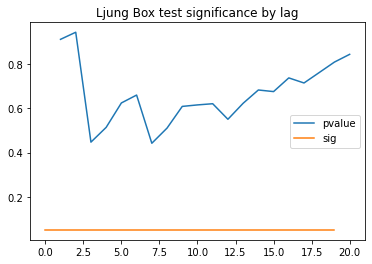

In [38]:
stat, norm, hetero, durbin_wats, zero_mean, idd_ser = lgb_eval.analyse_resids()

In [39]:
lgb_eval.model_wrapper.model

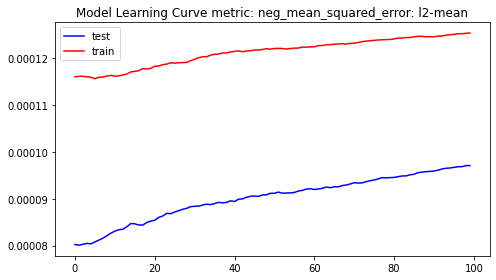

In [40]:
fig_lcurve = lgb_eval.learning_curve("Model Learning Curve")

In [41]:
#update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=durbin_wats)
data_dict["model_metrics"].update(zeor_mean=zero_mean)

# model performance
data_dict["model_metrics"].update(rmse=lgb_eval.rmse)
data_dict["model_metrics"].update(mse=lgb_eval.mse)
data_dict["model_metrics"].update(mae=lgb_eval.mae)
data_dict["model_metrics"].update(r2=lgb_eval.r2)
data_dict["model_metrics"].update(residuals=lgb_eval.resid_inv)

data_dict['model_metrics'].update(y_pred=lgb_eval.model_wrapper.y_pred)
data_dict['model_metrics'].update(y_test=lgb_eval.model_wrapper.y_test)
data_dict['model_metrics'].update(y_prices=df_w.sp_true_vals.iloc[y_test.index[0]:])

# Shap values

In [42]:
explainer = shap.TreeExplainer(lgb_eval.model_wrapper.model)
shap_values = explainer.shap_values(X_test)

In [43]:
idx = 8
print(f'idx {idx} resid values {round(lgb_eval.resid.iloc[idx], 5)}')
print(f'highest resid true value: {round(lgb_eval.y_test.iloc[idx], 5)}')
shap.force_plot(explainer.expected_value, shap_values[idx], X_test.iloc[0,:])

idx 8 resid values -0.00951
highest resid true value: -0.00303


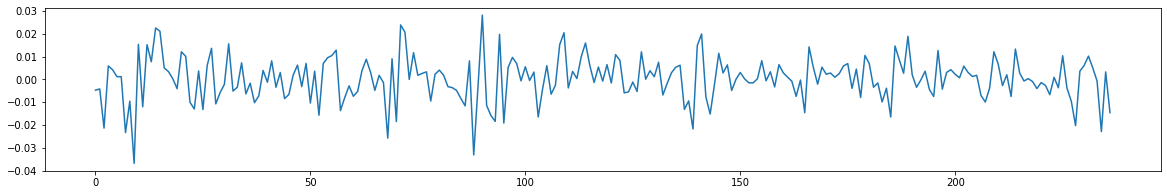

In [44]:
plt.figure(figsize=(20, 3))
plt.plot(lgb_eval.resid);

In [45]:
from_val = 0
to_val = len(X_test)
shap.force_plot(explainer.expected_value, shap_values[from_val : to_val], X_test.iloc[from_val : to_val])

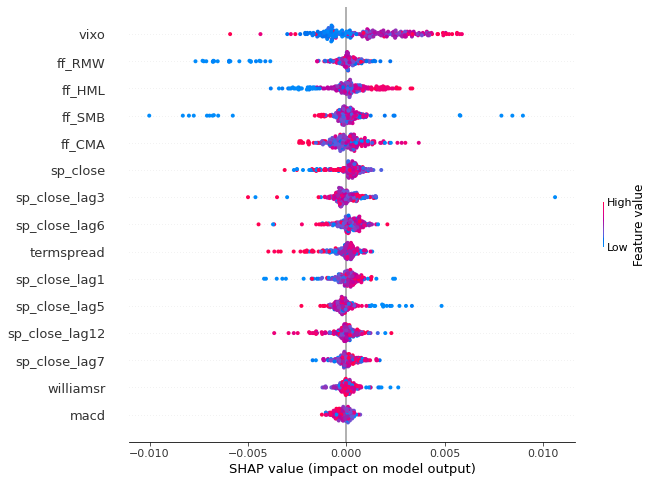

In [46]:
shap.summary_plot(shap_values, X_test, max_display=50, plot_size=(10, 8), show=False)

# Save model

In [39]:
save_model(model=lgb_eval.model_wrapper.model, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_truefit,
                        fig_lcurve], 
           fig_titles=['fig_truefit', 'fig_lcurve'], model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-05-02_lgb_daily_FF_TS_VX_years2021_2012_sp_close_lead1"? (y/n)


 y
